In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
from keras.utils import np_utils

'''LOAD DATA'''
Dir= 'C:/pythonwork/MHDD/'
x_train= np.load(Dir+'HMDD_Train_X.npy')
y_train=np.load(Dir+'HMDD_Train_Y.npy')
x_test=np.load(Dir+'HMDD_Test_X.npy')
y_test=np.load(Dir+'HMDD_Test_Y.npy')

'''PRE-PROCESSING'''
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
# n_Vld= int(np.floor(Vld_Splt* x_train.shape[0]))  # Num. of validation data

In [6]:
print('', x_train.shape,'\n',y_train.shape,'\n',x_test.shape,'\n',y_test.shape,'\n')

 (60000, 28, 28, 1) 
 (60000, 10) 
 (10000, 28, 28, 1) 
 (10000, 10) 



In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [8]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 210, kernel_size= 9, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 210))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 210)       17220     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 210)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 400, 210)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            33600     
_________________________________________________________________
lambda_1 (Lambda)    

In [9]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 10, kernel_size= 9, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 53, kernel_size= 9, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 53))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 10)        820       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 53)        42983     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 53)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 144, 53)           0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            8480      
__________

In [32]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters=10, kernel_size= 9, activation='relu', 
             padding= 'valid')(input_image)
x_2= Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 20 , kernel_size= 9, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 21, kernel_size= 9, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 21))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 10)        820       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 20)        16220     
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 21)          34041     
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 21)          0         
__________

In [11]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 10, kernel_size= 9, activation='relu', 
              padding= 'same')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 12 ,kernel_size= 9, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 18, kernel_size= 9, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 20,kernel_size= 9, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 20))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 10)        820       
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 12)        9732      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 20, 12)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 18)        17514     
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 18)        0         
__________

In [12]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_4= Sequential()
model_4.add(Conv2D(filters= 5, kernel_size= (9, 9), padding= 'valid', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters= 20, kernel_size= (9, 9), 
                    padding='same', activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dropout(0.6))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(num_classes, activation='softmax'))
print(model_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 20, 20, 5)         410       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 5)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 20)        8120      
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 10, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 500)               0         
__________

In [13]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 13s 236us/step - loss: 0.3628 - acc: 0.5929 - val_loss: 0.2648 - val_acc: 0.7217
Epoch 2/30
54546/54546 [==============================] - 11s 205us/step - loss: 0.2428 - acc: 0.7513 - val_loss: 0.2090 - val_acc: 0.7912
Epoch 3/30
54546/54546 [==============================] - 11s 204us/step - loss: 0.2071 - acc: 0.7972 - val_loss: 0.1960 - val_acc: 0.8025
Epoch 4/30
54546/54546 [==============================] - 11s 201us/step - loss: 0.1883 - acc: 0.8187 - val_loss: 0.1702 - val_acc: 0.8544
Epoch 5/30
54546/54546 [==============================] - 11s 201us/step - loss: 0.1771 - acc: 0.8328 - val_loss: 0.1661 - val_acc: 0.8555
Epoch 6/30
54546/54546 [==============================] - 11s 201us/step - loss: 0.1687 - acc: 0.8434

In [14]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 5s 98us/step - loss: 0.3949 - acc: 0.4844 - val_loss: 0.2607 - val_acc: 0.7217
Epoch 2/30
54546/54546 [==============================] - 5s 91us/step - loss: 0.2268 - acc: 0.7502 - val_loss: 0.1839 - val_acc: 0.8075
Epoch 3/30
54546/54546 [==============================] - 5s 86us/step - loss: 0.1816 - acc: 0.8022 - val_loss: 0.1556 - val_acc: 0.8423
Epoch 4/30
54546/54546 [==============================] - 5s 89us/step - loss: 0.1596 - acc: 0.8281 - val_loss: 0.1407 - val_acc: 0.8537
Epoch 5/30
54546/54546 [==============================] - 5s 88us/step - loss: 0.1462 - acc: 0.8450 - val_loss: 0.1325 - val_acc: 0.8684
Epoch 6/30
54546/54546 [==============================] - 5s 87us/step - loss: 0.1350 - acc: 0.8556 - val_loss: 0.1184 - val_acc: 0.8759
Epoch 7/30
54546/54546 [==============================] - 5s 86us/step - loss: 0.1270 - acc: 0.8652 

In [33]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 4s 75us/step - loss: 0.3161 - acc: 0.5837 - val_loss: 0.1920 - val_acc: 0.7745
Epoch 2/30
54546/54546 [==============================] - 3s 61us/step - loss: 0.1731 - acc: 0.7939 - val_loss: 0.1384 - val_acc: 0.8365
Epoch 3/30
54546/54546 [==============================] - 3s 62us/step - loss: 0.1356 - acc: 0.8412 - val_loss: 0.1181 - val_acc: 0.8608
Epoch 4/30
54546/54546 [==============================] - 3s 60us/step - loss: 0.1192 - acc: 0.8609 - val_loss: 0.1087 - val_acc: 0.8665
Epoch 5/30
54546/54546 [==============================] - 4s 74us/step - loss: 0.1073 - acc: 0.8740 - val_loss: 0.0927 - val_acc: 0.8927
Epoch 6/30
54546/54546 [==============================] - 4s 69us/step - loss: 0.0977 - acc: 0.8867 - val_loss: 0.0908 - val_acc: 0.8948
Epoch 7/30
54546/54546 [==============================] - 4s 71us/step - loss: 0.0900 - acc: 0.8936 

In [16]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 102us/step - loss: 0.4821 - acc: 0.2835 - val_loss: 0.3132 - val_acc: 0.6080
Epoch 2/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.2416 - acc: 0.7259 - val_loss: 0.1808 - val_acc: 0.8082
Epoch 3/30
54546/54546 [==============================] - 5s 83us/step - loss: 0.1663 - acc: 0.8225 - val_loss: 0.1319 - val_acc: 0.8608
Epoch 4/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.1274 - acc: 0.8625 - val_loss: 0.0944 - val_acc: 0.8938
Epoch 5/30
54546/54546 [==============================] - 5s 83us/step - loss: 0.0993 - acc: 0.8862 - val_loss: 0.0804 - val_acc: 0.9006
Epoch 6/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.0844 - acc: 0.9013 - val_loss: 0.0640 - val_acc: 0.9241
Epoch 7/30
54546/54546 [==============================] - 5s 85us/step - loss: 0.0741 - acc: 0.9118

In [17]:
"""CNN-3-CONV-LAYERS"""
model_4.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_4= model_4.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 3s 58us/step - loss: 1.3001 - acc: 0.5409 - val_loss: 0.8395 - val_acc: 0.7646
Epoch 2/30
54546/54546 [==============================] - 2s 44us/step - loss: 0.8163 - acc: 0.7271 - val_loss: 0.7064 - val_acc: 0.7946
Epoch 3/30
54546/54546 [==============================] - 3s 46us/step - loss: 0.6780 - acc: 0.7757 - val_loss: 0.5328 - val_acc: 0.8403
Epoch 4/30
54546/54546 [==============================] - 2s 40us/step - loss: 0.6100 - acc: 0.7991 - val_loss: 0.4739 - val_acc: 0.8647
Epoch 5/30
54546/54546 [==============================] - 2s 39us/step - loss: 0.5626 - acc: 0.8134 - val_loss: 0.4358 - val_acc: 0.8726
Epoch 6/30
54546/54546 [==============================] - 2s 39us/step - loss: 0.5214 - acc: 0.8271 - val_loss: 0.3974 - val_acc: 0.8843
Epoch 7/30
54546/54546 [==============================] - 2s 41us/step - loss: 0.4974 - acc: 0.8363 - val_loss: 0.3779 - val_acc:

In [18]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 1s 89us/step


0.9037

In [34]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 71us/step


0.929

In [35]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 74us/step


0.9322

In [36]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 72us/step


0.9565

In [37]:
"""CNN"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 75us/step


0.9258

In [38]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

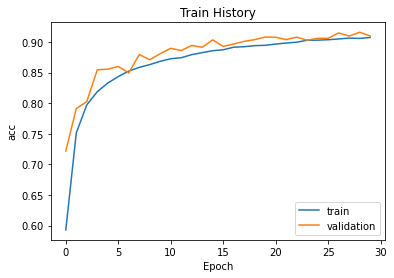

In [39]:
show_train_history(train_history_0, 'acc', 'val_acc')

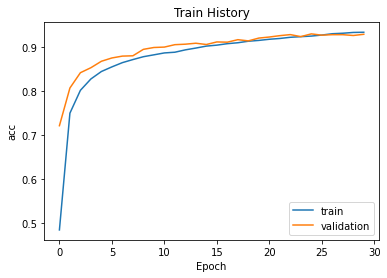

In [40]:
show_train_history(train_history_1, 'acc', 'val_acc')

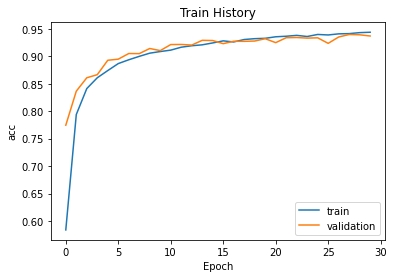

In [41]:
show_train_history(train_history_2, 'acc', 'val_acc')

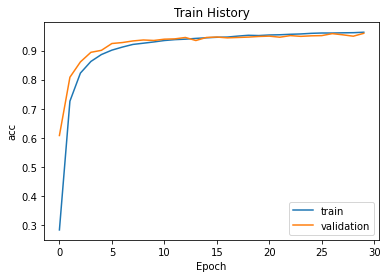

In [42]:
show_train_history(train_history_3, 'acc', 'val_acc')

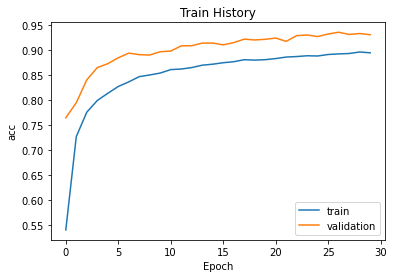

In [43]:
show_train_history(train_history_4, 'acc', 'val_acc')

In [44]:
# show_train_history(train_history_5, 'acc', 'val_acc')

In [45]:
# show_train_history(train_history_6, 'acc', 'val_acc')

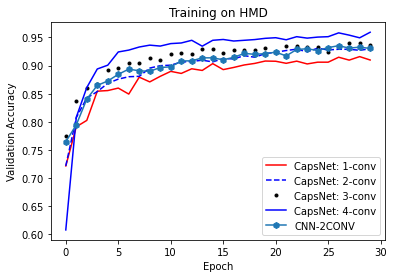

In [46]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
# plt.plot(train_history_5.history['val_acc'], 'c-')
# plt.plot(train_history_6.history['val_acc'], 'g*-')
# plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on HMD')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CNN-2CONV'], loc='best')
plt.show()